%
\section{Classification Dataset: Kaggle Congressional Voting (\href{https://www.kaggle.com/c/184702-tu-ml-ss-21-congressional-voting/overview}{link to dataset})}

The Congressional Voting dataset is used for classification, it is a prediction on the party (republican or democrat) for politicians of the congress. It consists of 218 samples and 17 attributes where 15 attributes are given as string values (but corresponding to booleans) and 1 further as numerical value, the id of the row, which is not relevant so we drop it during the preprocessing step. This dataset is quite small but with quite big dimension. 
The label is an ordinal value, "democrat" or "republican", and during the preprocessing step we transform it to respectively 0 and 1 value, and we replace "y" and "n" by 1 and 0. Hence, we have now only binary values. The description of the training dataset is the following {insert figure}.

We can see that there are some missing values, and we have the repartition of missing values among samples with the following table {insert table}. We can notice that the feature "export-administration-act-south-africa" is the most incomplete one, with 23% missing values, the other features having less than 11% missing values.
The threshold for the minimum number of known values to conserve a row will be a tuning parameter for the algorithms.
We also tried to impute them with a multivariate feature imputation, but the results were better with the random method (at least 15% of decrease in accuracy for each algorithm).

We have to notice about this dataset that the false negatives and false positives show no theoritical difference: we do not have to privilege one over the other. So the performance by class should be barely the same. What is more, we can see that the training dataset is inbalanced, so we will use balanced indicators (such as balanced accuracy and f1 score), and make sure that our precision and recall are close.

In [32]:
import pandas as pd
import random
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

training = pd.read_csv("./CongressionalVotingID.shuf.lrn.csv")
training_init = training.copy()

# Preprocessing and analysis of dataset

In [33]:
# modify the content to manipulate only binary values

def transform_to_binary(data) :
    #we drop the ID column which is not relevant
    d = data.drop('ID', axis=1)

    #we transform yes in 1 and no in 0, we convert "unknown" in NaN value and republican in 1 and democrat in 0, thus we have 
    #only binary values
    d = d.applymap(lambda x : 1 if x == "y" else (0 if x == "n" else (np.nan if x == "unknown" else (1 if x == "republican" else 0))))
    return d

# drops the samples of the training with less than 'thres' values

def clean_rows(training, thres) :
    return training.dropna(axis=0, thresh=thres, subset=None, inplace=False)

# imputate the missing values following two possible methods : if imputation is true, we use the multivariate feature imputation
# provided by sklearn, if not, we just replace by random values

def imputate(data, imputation) :
    # imputation
    imp = IterativeImputer(max_iter=10, random_state=0)
    if (imputation) :
        try:
            t = data.drop('class', axis=1)
        except:
            # it's the test set and we already have trained our imputation function
            print("HERE")
            array = np.round(imp.transform(data))
            data = pd.DataFrame(array, columns = data.columns)
        else:
            # we fit the multivariate feature imputation
            imp.fit(t)
            # we use it on training dataset
            array = np.round(imp.transform(t))
            t = pd.DataFrame(array, columns = t.columns)
            t.index = data.index
            t['class'] = data['class']
            data = t
    else :
        #we transform unknown values in 1 or 0 randomly
        data = data.fillna(random.randint(0,1))
    return data
    
# returns a table with the number of missing values in the first column and the number of samples concerned in the second   

def number_of_samples_per_number_of_missing_values(data) :
    # count how many rows have 'x' missing values
    m = data.copy()
    n = m.isna().sum(axis=1)
    n.name = "missing values in row"
    d = n.value_counts(sort=False)
    return d

# plots the number of "yes, no, unknown" votes for each decision

def plot_count(data) :
    
    DF=[]
    for i in range(1, len(data.columns)) :
        DF.append(data[data.columns[i]].value_counts(dropna=False))
    df = pd.concat(DF, axis=1)
    df = df.transpose()
    if len(df.columns) == 3 :
        df.columns = ["No","Yes","Unknown"]
    else :
        df.columns = ["No","Yes"]
    
    df.plot(kind='bar', figsize = (15,10))
    
    plt.title("Number of samples per class")
    plt.ylabel('Count')
    plt.gca().xaxis.set_tick_params(rotation=90)

# plots the final result of classification

def plot_result_classes(data) :
    countplt, ax = plt.subplots(figsize = (15,10))
    ax = sns.countplot(data=data, x='class')
    ax.set_title("#Votes")
    ax.set_xticklabels(["democrat","republican"], rotation=45)

# plots the percentage of republicans among all voters having voted for "yes, no, unknown" for each decision
# also plots the final decision taken (percentage of votes for yes among all voters)

def plot_decisions(data_with_na, missing_values) :
    
    data = data_with_na.copy()
    data.fillna(-1)
    DF=[]
    F=[]
    for i in range(1, len(data.columns)) :
        DF.append(data.groupby(data.columns[i])['class'].mean())
        F.append(data[data.columns[i]].mean())
    
    df = pd.concat(DF, axis=1)
    df = df.transpose()
    df.index = data.columns[1:]
    df["final decision"] = F
    
    if missing_values :
        df.columns = ["no","yes","unknown","final decision"]
    else :
        df.columns = ["no","yes","final decision"]

    df.plot(kind='bar', figsize = (15,10))
        
    title_ = "Who took the decision ? Close to 1: decision taken by republicans. Close to 0: decision taken by democrats. Green bar : decision finally taken if > 0.5."
    plt.title(title_)
    plt.ylabel('Relative part of republicans in a vote / Green : percentage of yes')
    plt.gca().xaxis.set_tick_params(rotation=90)

In [34]:
training = transform_to_binary(training)
number_of_samples_per_number_of_missing_values(training)

0     118
1      61
2      21
3      10
4       1
5       2
6       2
9       1
14      1
15      1
Name: missing values in row, dtype: int64

In [35]:
training.describe()

,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
count,218.000000,211.000000,194.000000,209.000000,211.000000,212.000000,213.000000,211.000000,213.000000,209.000000,216.000000,206.000000,203.000000,206.000000,210.000000,199.000000,168.000000
mean,0.366972,0.459716,0.541237,0.598086,0.407583,0.504717,0.629108,0.559242,0.591549,0.511962,0.527778,0.398058,0.369458,0.529126,0.595238,0.437186,0.845238
std,0.483088,0.499560,0.499586,0.491462,0.492553,0.501161,0.484182,0.497659,0.492705,0.501057,0.500387,0.490690,0.483851,0.500367,0.492019,0.497290,0.362759
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


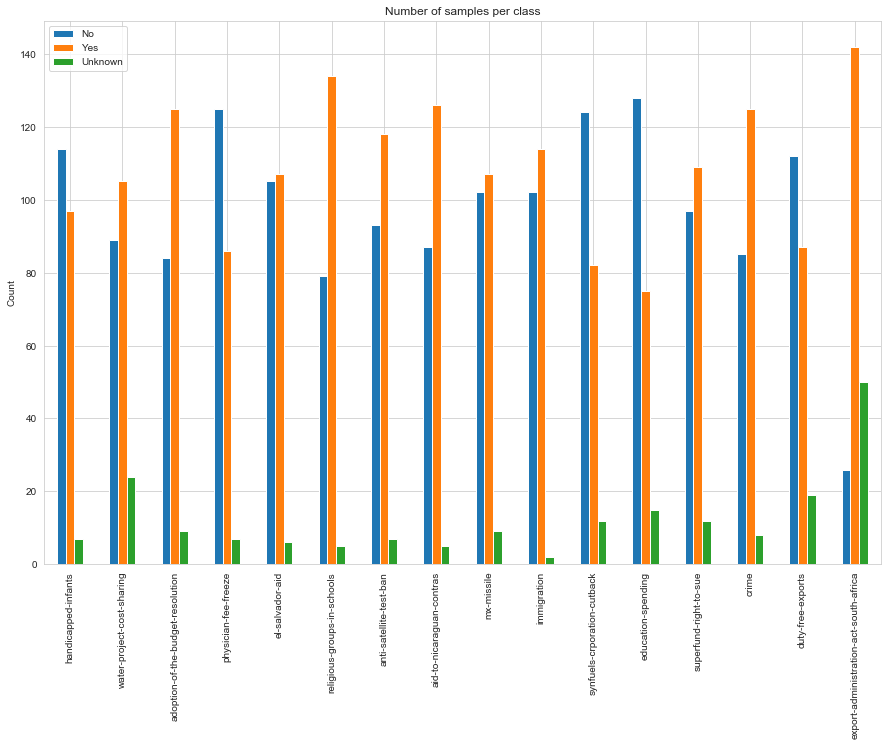

In [36]:
plot_count(training)

In [37]:
training = clean_rows(training, 14)
training = imputate(training, False)
training.describe()

,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,0.361905,0.476190,0.576190,0.609524,0.414286,0.519048,0.628571,0.571429,0.585714,0.523810,0.533333,0.419048,0.400000,0.538095,0.600000,0.480952,0.876190
std,0.481700,0.500626,0.495342,0.489023,0.493775,0.500831,0.484341,0.496054,0.493775,0.500626,0.500080,0.494582,0.491069,0.499738,0.491069,0.500831,0.330151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


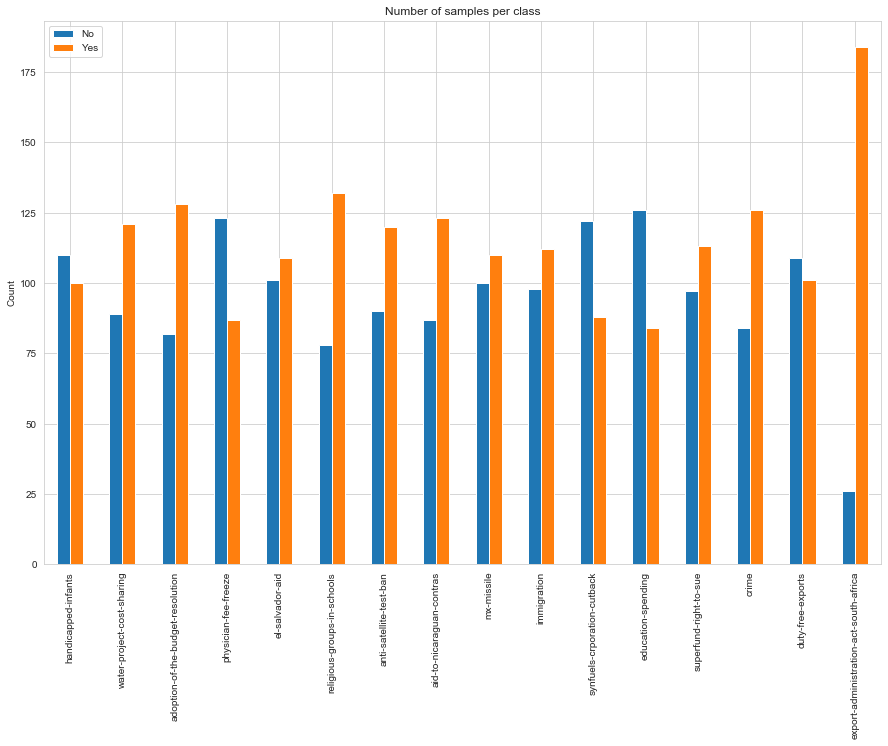

In [38]:
training_for_plot = training.copy()
plot_count(training)

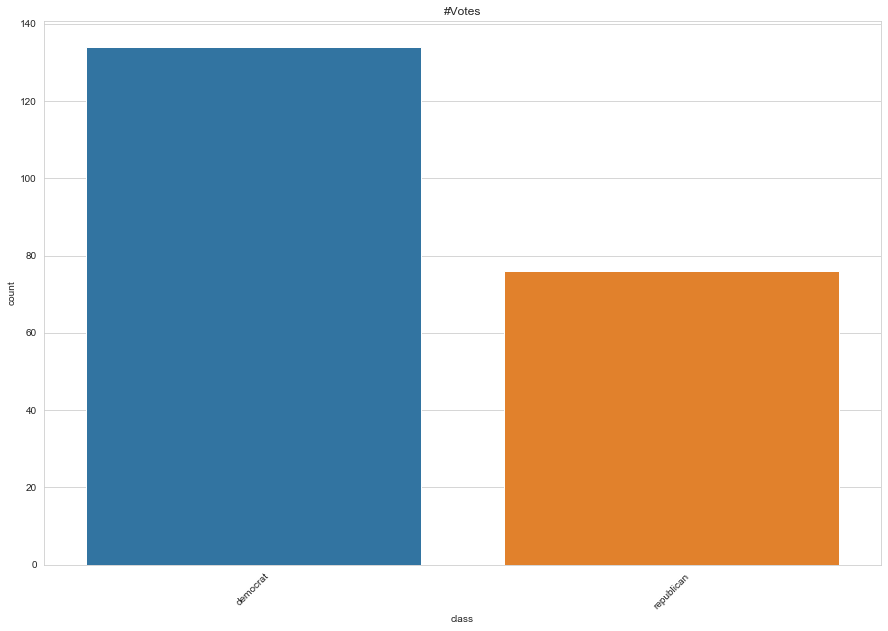

In [39]:
plot_result_classes(training)

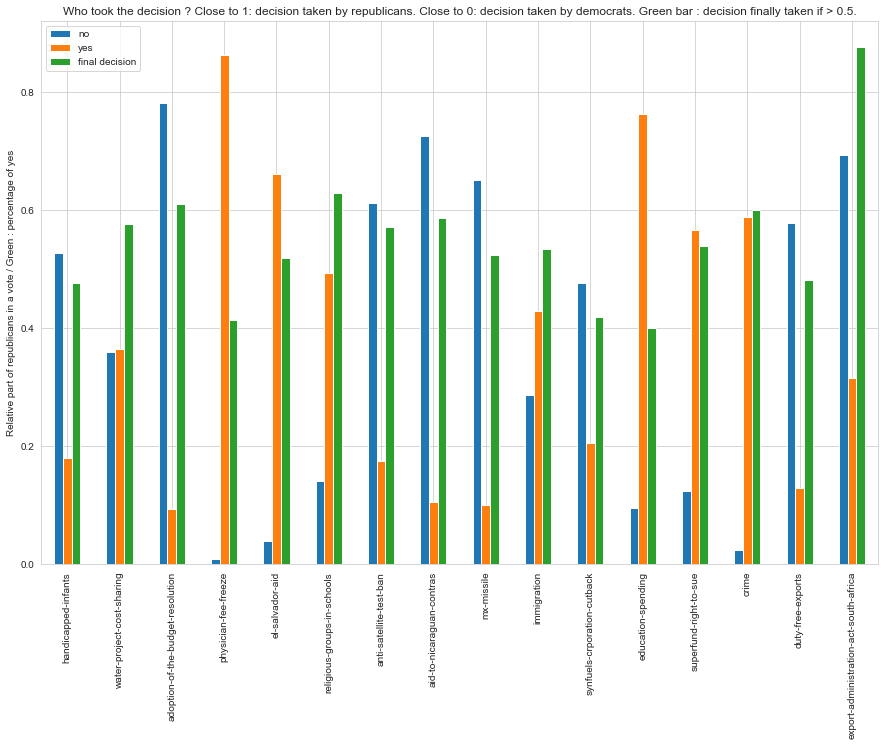

In [40]:
plot_decisions(training, False)

# Training models : perceptron, random forest and naive Bayes

We decide to take cv=5 (number of folds) for the cross validation because our number of samples is small.

In [41]:
from sklearn.model_selection import train_test_split

# preprocessing with as parameters : 
#    thres : threshold for the number of minimum known values
#    imp : if true, uses the mmultivariate imputation, if not, fills missing values with random binary values
# outputs the training set, the target for the training, the test set and the target for the test set

def preprocessing(thres, imp) :
    training = transform_to_binary(training_init)
    training = clean_rows(training, thres)
    training = imputate(training, imp)
    
    train_target = training.drop('class', axis=1)
    train_set, test_set = train_test_split(training, test_size=0.2, random_state=42)
    train = np.array(train_set)[:,1:]
    train_target = np.array(train_set)[:,0]
    test = np.array(test_set)[:,1:]
    test_target = np.array(test_set)[:,0]
    
    return train, train_target, test, test_target

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, cross_val_score

import seaborn as sns
sns.set_style('whitegrid')

# realizes the grid search with a dictionary of parameters as grid input, or if there is no grid input, creates a perceptron
# with the inputs as parameters

def create_perceptron(train_data, target, grid=[], **kwargs):
    if grid != []:
        clf = GridSearchCV(Perceptron(), grid, refit = "balanced_accuracy", verbose = 3,n_jobs=4, cv=5)
    else:
        clf = Perceptron(**kwargs)
    clf.fit(train_data, target)
    return clf

# realizes the grid search with a dictionary of parameters as grid input, or if there is no grid input, creates a random forest
# with the inputs as parameters

def create_rnd_forest(train_data, target, grid=[], **kwargs):
    if grid != []:
        clf = GridSearchCV(RandomForestClassifier(), grid, refit = "balanced_accuracy", verbose = 3,n_jobs=4, cv=5)
    else:
        clf = RandomForestClassifier(**kwargs)
    clf.fit(train_data, target)
    return clf

# realizes the grid search with a dictionary of parameters as grid input, or if there is no grid input, creates a naive Bayes
# with the inputs as parameters

def create_nb(train_data, target, grid=[], **kwargs) :
    if grid != []:
        clf = GridSearchCV(MultinomialNB(), grid, refit = "balanced_accuracy", verbose = 3,n_jobs=4, cv=5)
    else :
        clf =MultinomialNB(**kwargs)
    clf.fit(train_data , target)
    return clf

def most_frequent(List):
    counter = 0
    num = List[0]
      
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
  
    return num
    
# evaluates the algorithm by printing the relevant metrics and the confusion matrix for both train and test sets
# outputs the metrics as a dictionary
    
def evaluate_algo(algo, test_data, test_target, train_data, train_target):
    
    print(algo)
    pred_test  = algo.predict(test_data)
    pred_train = algo.predict(train_data)
    
    # outputs
    metrics_train = {"accuracy": 0, "balanced_accuracy": 0, "roc_auc": 0, "f1": 0, "precision": 0, "recall": 0}
    metrics_test = {"accuracy": 0, "balanced_accuracy": 0, "roc_auc": 0, "f1": 0, "precision": 0, "recall": 0}
    
    metrics_test["accuracy"] = accuracy_score(test_target, pred_test)
    metrics_test["balanced_accuracy"] = balanced_accuracy_score(test_target, pred_test)
    metrics_test["roc_auc"] = roc_auc_score(test_target, pred_test)
    metrics_test["f1"] = f1_score(test_target, pred_test)
    metrics_test["precision"] = precision_score(test_target, pred_test)
    metrics_test["recall"] = recall_score(test_target, pred_test)
    metrics_test["fbeta"] = fbeta_score(test_target, pred_test, 1)
    
    # report of metrics
    for score in metrics_train.keys():
        sc_train = cross_val_score(algo, train_data, train_target, cv=5, scoring=score).mean()
        print("cross validation " + score + " train : "+ str(sc_train))
        metrics_train[score] = sc_train
    
        print(score + " test : "+ str(metrics_test[score]))
    
    # plot of the confusion matrix
    # confusion matrix
    cmat = confusion_matrix(test_target, pred_test)
    cmat_train = confusion_matrix(train_target, pred_train)
    print("train : " + str(cmat_train[0]) + "   test :  " + str(cmat[0]) )
    print("        " + str(cmat_train[1]) + "           " + str(cmat[1]) )
    
    return metrics_test, metrics_train

# Perceptron

Test of different preprocessing methods with the optimal parameters found with grid search. We launch it 5 times to prevent a too large variation because of the random of the preprocessing.

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidat

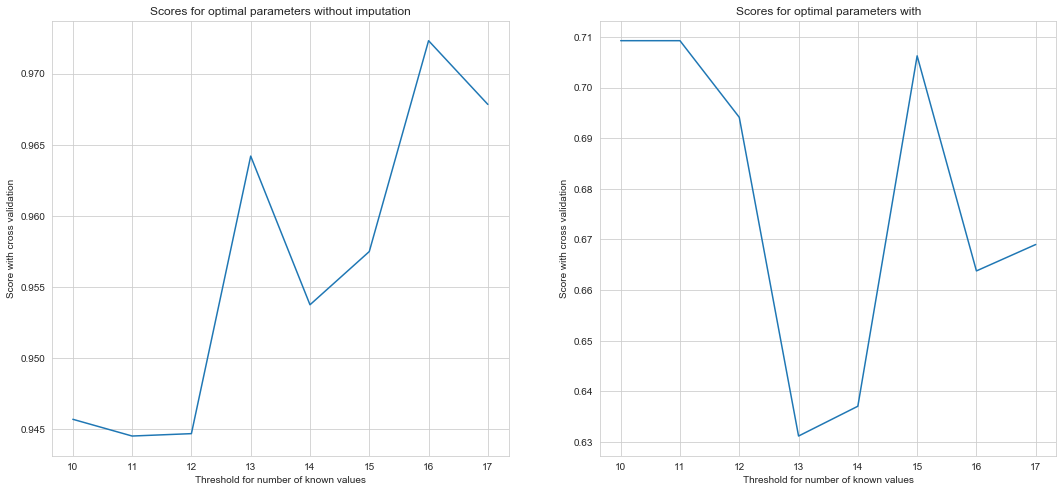

In [45]:
import warnings
warnings.filterwarnings('ignore')

param_grid = {'eta0': [0.1,0.2,0.3,0.4],  
              'early_stopping': [True, False],
              'max_iter':[10,20,30,100],
              'tol':[1e-4,1e-3,1e-2,1e-1],
              'penalty':["l2","l1","elasticnet","None"]}  

L = []
subpl, axes = plt.subplots(1, 2, figsize = (18,8))

for imputation in [True, False] :
    thresholds = np.arange(10,18)
    scores = []
    for thres in thresholds :
        print(thres)
        training = training_init.copy()
        text = "imputation: " + str(imputation) + ", threshold = " + str(thres)
        score = 0
        PPN = []
        PREPROS = []
        
        for i in range(5) :
            train, train_target, test, test_target = preprocessing(thres, imputation)
            PPN.append( create_perceptron(train, train_target, grid = param_grid) )
            score += PPN[i].best_score_
            PREPROS.append([train, train_target, test, test_target])
        
        L.append((text,PPN,PREPROS))
        scores.append(score/5)
    
    fig = axes[int(imputation)]
    fig.plot(thresholds, scores)
    title_ = "Scores for optimal parameters "
    if (imputation) :
        title_ += "with"
    else :
        title_ += "without"
        title_ += " imputation"
    fig.set_title(title_)
    fig.set(xlabel = "Threshold for number of known values", ylabel = "Score with cross validation")

We can see that the relevant imputation is the random imputation, and the optimal threshold is 13.

Now with this preprocessing method, we evaluate the perceptron method optimized by grid search

In [80]:
prepro_text = ""
best_ppn = None
datasets = []
score = 0
for (text, PPN, PREPROS) in L :
    new_score = 0
    for i in range(5) :
        prepro = PREPROS[i]
        ppn = PPN[i]
        train, train_target, test, test_target = prepro[0], prepro[1], prepro[2], prepro[3]
        new_score += ppn.best_score_
    new_score /= 5
    if new_score > score :
        score = new_score
        prepro_text = text
        best_ppn = PPN
        datasets = PREPROS
        #evaluate_algo(ppn, test, test_target, train, train_target)

print(prepro_text)

best_params = map(lambda x: x.best_params_, best_ppn)
best_params = list(best_params)

for param in best_params :
    print(param)
print("\n")

# most frequent parameters among best perceptrons
best_param = most_frequent(best_params)
ind = best_params.index(best_param)

datasets = datasets[ind]
best_ppn = best_ppn[ind]
train, train_target, test, test_target = datasets[0], datasets[1], datasets[2], datasets[3]
ppn = create_perceptron(train, train_target, **best_ppn.best_params_)
metrics_ppn = evaluate_algo(ppn, test, test_target, train, train_target)

imputation: False, threshold = 16
{'early_stopping': False, 'eta0': 0.1, 'max_iter': 20, 'penalty': 'elasticnet', 'tol': 0.01}
{'early_stopping': False, 'eta0': 0.2, 'max_iter': 10, 'penalty': 'elasticnet', 'tol': 0.0001}
{'early_stopping': False, 'eta0': 0.1, 'max_iter': 20, 'penalty': 'elasticnet', 'tol': 0.01}
{'early_stopping': False, 'eta0': 0.2, 'max_iter': 10, 'penalty': 'elasticnet', 'tol': 0.0001}
{'early_stopping': False, 'eta0': 0.2, 'max_iter': 10, 'penalty': 'elasticnet', 'tol': 0.0001}


Perceptron(eta0=0.2, max_iter=10, penalty='elasticnet', tol=0.0001)
cross validation accuracy train : 0.9724137931034482
accuracy test : 0.9166666666666666
cross validation balanced_accuracy train : 0.9742424242424242
balanced_accuracy test : 0.9318181818181819
cross validation roc_auc train : 0.9919191919191919
roc_auc test : 0.9318181818181819
cross validation f1 train : 0.9651515151515152
f1 test : 0.9032258064516129
cross validation precision train : 0.951048951048951
precision test :

Most of the time, we have a strong overfitting with grid search, so we have to optimize it manually. We use the test set to compare and be aware if we are overfitting too much. Because of the random values, the optimize values can change from one run to another, but the changes are not huge.

First we optimize the threshold of the preprocessing (we consider directly a random imputation)

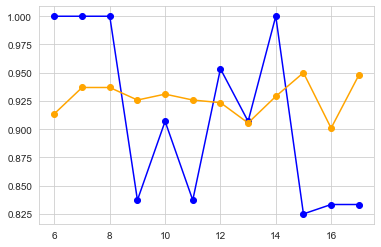

In [42]:
vals = np.arange(6,18)
scores    = []
scores_cv = []
for x in vals:
    train, train_target, test, test_target = preprocessing(x, False)
    ppn = create_perceptron(train, train_target, eta0=0.1, max_iter=10,tol=0.1, early_stopping=False, penalty=None)
    scores.append(ppn.score(test, test_target))
    scores_cv.append(cross_val_score(ppn, train, train_target,scoring="accuracy", cv=5).mean())
plt.plot(vals, scores,"o-", color="blue")
plt.plot(vals, scores_cv,"o-", color="orange")

Best seems to be 14 as threshold, because with 6-8 as threshold we are too sensible to random values and with a threshold of 14 we have one of the best accuracy for trainset and no difference between accuracies of the two datasets.

Now we optimize the stopping criterion

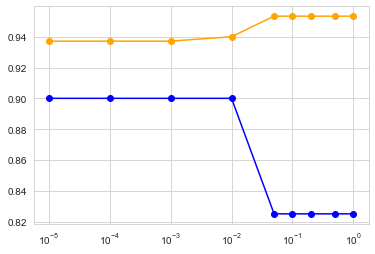

In [43]:
train, train_target, test, test_target = preprocessing(15, imputation)

vals      = np.array([1e-5,1e-4,1e-3,1e-2,0.05,0.1,0.2,0.5,1])
scores    = []
scores_cv = []
for x in vals:
    ppn = create_perceptron(train, train_target, eta0=0.1, max_iter=10,tol=x, penalty=None)
    scores.append(ppn.score(test, test_target))
    scores_cv.append(cross_val_score(ppn, train, train_target,scoring="balanced_accuracy", cv=5).mean())
plt.semilogx(vals, scores,"o-", color="blue")
plt.semilogx(vals, scores_cv,"o-", color="orange")

0.01 seems to be the best stopping criterion to have the best accuracy and the most little difference between accuracies.

Now we choose the penalty parameter

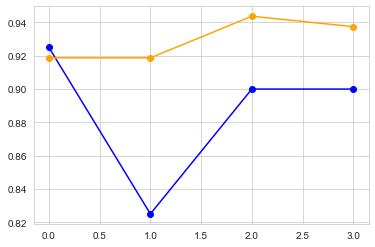

In [44]:
vals_names = ["l2","l1","elasticnet","None"]
vals = [0,1,2,3]
scores    = []
scores_cv = []
for x in vals_names:
    ppn = create_perceptron(train, train_target, eta0=0.1, max_iter=10,tol=0.01, early_stopping=False, penalty=x)
    scores.append(ppn.score(test, test_target))
    scores_cv.append(cross_val_score(ppn, train, train_target,scoring="accuracy", cv=5).mean())
plt.plot(vals, scores,"o-", color="blue")
plt.plot(vals, scores_cv,"o-", color="orange")

It can change between runs but most of the time "None" is among the best choices.

Now we optimize maximum number of iterations

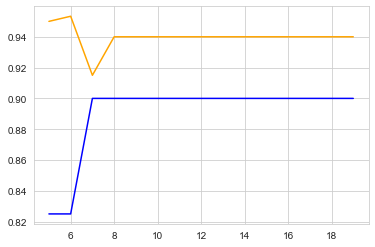

In [45]:
# maximum iterations
vals      = np.arange(5,20)
scores    = []
scores_cv = []
for x in vals:
    ppn = create_perceptron(train, train_target, eta0=0.1, max_iter=x,tol=0.01,penalty="None")
    scores.append(ppn.score(test, test_target))
    scores_cv.append(cross_val_score(ppn, train, train_target,scoring="balanced_accuracy", cv=5).mean())
plt.plot(vals, scores, color="blue")
plt.plot(vals, scores_cv, color="orange")

We try to have a stable accuracy, so we choose a max_iter of 14.

Now we optimize the learning rate

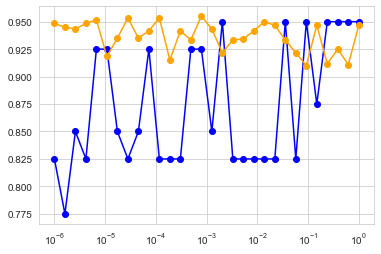

In [46]:
vals      = np.logspace(-6,0,num=30)
scores    = []
scores_cv = []
for x in vals:
    ppn = create_perceptron(train, train_target, eta0=x, max_iter=14,tol=0.01,penalty="None")
    scores.append(ppn.score(test, test_target))
    scores_cv.append(cross_val_score(ppn, train, train_target,scoring="balanced_accuracy", cv=5).mean())
plt.semilogx(vals, scores,"o-", color="blue")
plt.semilogx(vals, scores_cv,"o-", color="orange")

A learning rate close to 1 is great for both datasets, we choose 0.5.

Finally we choose if we want an early stopping

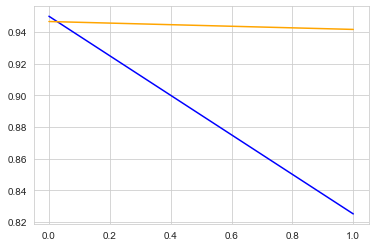

In [48]:
# early stopping
bools     = [False,True]
vals      = [0,1]
scores    = []
scores_cv = []
for x in bools :
    ppn = create_perceptron(train, train_target, eta0=0.5, max_iter=14,tol=0.01,penalty="None", early_stopping=x)
    scores.append(ppn.score(test, test_target))
    scores_cv.append(cross_val_score(ppn, train, train_target,scoring="balanced_accuracy", cv=5).mean())
plt.plot(vals, scores, color="blue")
plt.plot(vals, scores_cv, color="orange")

No early stopping is more stable and makes a huge difference for testset in a lot of cases.

Now we create the perceptron that we got manually and we evaluate it :

In [49]:
ppn = create_perceptron(train, train_target, eta0=0.5, max_iter=14,tol=0.01, early_stopping=False)
metrics_ppn = evaluate_algo(ppn, test, test_target, train, train_target)

Perceptron(eta0=0.5, max_iter=14, tol=0.01)
cross validation accuracy train : 0.95
accuracy test : 0.95
cross validation balanced_accuracy train : 0.9466666666666667
balanced_accuracy test : 0.9285714285714286
cross validation roc_auc train : 0.99
roc_auc test : 0.9285714285714286
cross validation f1 train : 0.934125874125874
f1 test : 0.923076923076923
cross validation precision train : 0.9523809523809523
precision test : 1.0
cross validation recall train : 0.9333333333333333
recall test : 0.8571428571428571
train : [95  6]   test :  [26  0]
        [ 0 59]           [ 2 12]


So finally we have a perceptron which is still overfitting but which seems better, with clearly a problem of recall for test set, eg it creates a lot of democrats who are not. It seems clearly not ideal.

# Random forest

Test of different preprocessing methods with the optimal parameters found with grid search

In [ ]:
param_grid = {'criterion': ["gini", "entropy"],
              'n_estimators': [200],
              #'min_samples_leaf': [0.01, 1, 2, 3, 4, 5],
              #'ccp_alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1],
              #'min_samples_split': [0.01, 0.04, 0.07, 0.1, 0.15, 0.2, 0.3, 0.5]
             }  

L = []
subpl, axes = plt.subplots(1, 2, figsize = (18,8))

for imputation in [True, False] :
    thresholds = np.arange(11,18)
    scores = []
    for thres in thresholds :
        print(thres)
        training = training_init.copy()
        train, train_target, test, test_target = preprocessing(thres, imputation)
        rdf = create_rnd_forest(train, train_target, grid = param_grid)
        text = "imputation: " + str(imputation) + ", threshold = " + str(thres)
        L.append((text,rdf,[train, train_target, test, test_target]))
        scores.append(rdf.best_score_)
    
    fig = axes[int(imputation)]
    fig.plot(thresholds, scores)
    title_ = "Scores for optimal parameters "
    if (imputation) :
        title_ += "with"
    else :
        title_ += "without"
        title_ += " imputation"
    fig.set_title(title_)
    fig.set(xlabel = "Threshold for number of known values", ylabel = "Score with cross validation")

We can see that the relevant imputation is the random imputation, and the optimal threshold is 17.

Now with this preprocessing method, we evaluate the random forest method optimized by grid search

In [ ]:
prepro_text = ""
best_rdf = None
datasets = []
score = 0
for (text, rdf, prepro) in L :
    train, train_target, test, test_target = prepro[0], prepro[1], prepro[2], prepro[3]
    new_score = rdf.best_score_
    if new_score > score :
        score = new_score
        prepro_text = text
        best_rdf = rdf
        datasets = prepro
    #evaluate_algo(rdf, test, test_target, train, train_target)
print(prepro_text)
print(rdf.best_params_)
print("\n")

train, train_target, test, test_target = datasets[0], datasets[1], datasets[2], datasets[3]
rdf = create_rnd_forest(train, train_target, **best_rdf.best_params_)
metrics_rdf = evaluate_algo(rdf, test, test_target, train, train_target)

We can see that with the grid search we have again a very strong overfitting, so we have to optimize it manually. We use the test set to compare and be aware if we are overfitting too much. Because of the random values, the optimize values can change from one run to another, but the changes are not huge.

First we optimize the threshold of the preprocessing (we consider directly a random imputation)

In [ ]:
vals = np.arange(6,18)
scores    = []
scores_cv = []
for x in vals:
    train, train_target, test, test_target = preprocessing(x, False)
    rdf = create_rnd_forest(train, train_target, criterion="gini", n_estimators=300)
    scores.append(rdf.score(test, test_target))
    scores_cv.append(cross_val_score(rdf, train, train_target,scoring="accuracy", cv=5).mean())
plt.plot(vals, scores,"o-", color="blue")
plt.plot(vals, scores_cv,"o-", color="orange")

We choose 13 because it is the best accuracy for trainset and we are not overfitting too much.

Now we choose the right criterion between Gini and entropy

In [ ]:
# criterion
vals      = ["gini", "entropy"]
scores    = []
scores_cv = []
for x in vals:
    train, train_target, test, test_target = preprocessing(13, False)
    rdf = create_rnd_forest(train, train_target, criterion=x, n_estimators=500)
    scores.append(rdf.score(test, test_target))
    scores_cv.append(cross_val_score(rdf, train, train_target,scoring="balanced_accuracy", cv=5).mean())
plt.plot(vals, scores, color="blue")
plt.plot(vals, scores_cv, color="orange")

It can change between runs but most of the time "Entropy" is the best choice.

Now we optimize the minimum number of samples on a leaf (0.01 is a fraction)

In [ ]:
# min_samples_leaf
vals      = [0.01, 1, 2, 3, 4, 5]
scores    = []
scores_cv = []
for x in vals:
    rdf = create_rnd_forest(train, train_target, criterion="entropy", n_estimators=500, min_samples_leaf=x)
    scores.append(rdf.score(test, test_target))
    scores_cv.append(cross_val_score(rdf, train, train_target,scoring="balanced_accuracy", cv=5).mean())
plt.plot(vals, scores, color="blue")
plt.plot(vals, scores_cv, color="orange")

The best choice is 3, to have the best accuracy on test set and not too much underfitting

Now we optimize the complexity parameter used for Minimal Cost-Complexity Pruning

In [ ]:
# ccp_alpha 
vals      = [1e-4, 1e-3, 1e-2, 1e-1, 1]
scores    = []
scores_cv = []
for x in vals:
    rdf = create_rnd_forest(train, train_target, criterion="entropy", n_estimators=200, min_samples_leaf=3, ccp_alpha=x)
    scores.append(rdf.score(test, test_target))
    scores_cv.append(cross_val_score(rdf, train, train_target,scoring="balanced_accuracy", cv=5).mean())
plt.semilogx(vals, scores, color="blue")
plt.semilogx(vals, scores_cv, color="orange")

We take cpp_alpha = 0.001 because it's the optimum for the trainset and it is relatively stable

Finally we optimize the mimum samples to split a node

In [ ]:
# min_samples_split
vals      = [0.01, 0.04, 0.07, 0.1, 0.15, 0.2, 0.3, 0.5]
scores    = []
scores_cv = []
for x in vals:
    rdf = create_rnd_forest(train, train_target, criterion="entropy", n_estimators=200, min_samples_leaf=2, ccp_alpha=0.001, min_samples_split=x)
    scores.append(rdf.score(test, test_target))
    scores_cv.append(cross_val_score(rdf, train, train_target,scoring="balanced_accuracy", cv=5).mean())
plt.plot(vals, scores, color="blue")
plt.plot(vals, scores_cv, color="orange")

0.01 is always among the best choices.

Now we create the random forest that we got manually and we evaluate it :

In [ ]:
rdf = create_rnd_forest(train, train_target, criterion="entropy", n_estimators=200, min_samples_leaf=2, ccp_alpha=0.001, min_samples_split=0.01)
metrics_rdf = evaluate_algo(rdf, test, test_target, train, train_target)

So finally we have a random forest which performs very well but maybe we introduced too much bias with the test set. With more samples it would have been better to create a third set which is totally independant and test it again on this validation set.

# Naive Bayes

Test of different preprocessing methods with the optimal parameters found with grid search

In [ ]:
# test of different preprocessing methods with the optimal parameters 

import warnings
warnings.filterwarnings('ignore')

param_grid = {'alpha': [1e-2, 1e-1, 0.5, 1, 10, 100]}  

L = []
subpl, axes = plt.subplots(1, 2, figsize = (18,8))

for imputation in [True, False] :
    thresholds = np.arange(10,18)
    scores = []
    for thres in thresholds :
        training = training_init.copy()
        train, train_target, test, test_target = preprocessing(thres, imputation)
        nb = create_nb(train, train_target, grid = param_grid)
        text = "imputation: " + str(imputation) + ", threshold = " + str(thres)
        L.append((text,nb,[train, train_target, test, test_target]))
        scores.append(nb.best_score_)
    
    fig = axes[int(imputation)]
    fig.plot(thresholds, scores)
    title_ = "Scores for optimal parameters "
    if (imputation) :
        title_ += "with"
    else :
        title_ += "without"
        title_ += " imputation"
    fig.set_title(title_)
    fig.set(xlabel = "Threshold for number of known values", ylabel = "Score with cross validation")

We can see that the relevant imputation is the random imputation, and the optimal threshold is 17.

Now with this preprocessing method, we evaluate the random forest method optimized by grid search

In [ ]:
# get best parameters and preprocessing method, and evaluate the optimized perceptron method

prepro_text = ""
best_nb = None
datasets = []
score = 0
for (text, nb, prepro) in L :
    train, train_target, test, test_target = prepro[0], prepro[1], prepro[2], prepro[3]
    new_score = nb.best_score_
    if new_score > score :
        score = new_score
        prepro_text = text
        best_nb = nb
        datasets = prepro
    #evaluate_algo(nb, test, test_target, train, train_target)
print(prepro_text)
print(nb.best_params_)
print("\n")

train, train_target, test, test_target = datasets[0], datasets[1], datasets[2], datasets[3]
nb = create_nb(train, train_target, **best_nb.best_params_)
metrics_nb = evaluate_algo(nb, test, test_target, train, train_target)

We can see that with the grid search we have again a very strong overfitting, so we have to optimize it manually. We use the test set to compare and be aware if we are overfitting too much. Because of the random values, the optimize values can change from one run to another, but the changes are not huge.

First we optimize the threshold of the preprocessing (we consider directly a random imputation)

In [ ]:
# threshold for preprocessing
vals = np.arange(6,18)
scores    = []
scores_cv = []
for x in vals:
    train, train_target, test, test_target = preprocessing(x, False)
    nb = create_nb(train, train_target, )
    scores.append(nb.score(test, test_target))
    scores_cv.append(cross_val_score(nb, train, train_target,scoring="accuracy", cv=5).mean())
plt.plot(vals, scores,"o-", color="blue")
plt.plot(vals, scores_cv,"o-", color="orange")

We choose 16 because it is the best accuracy for trainset and we are not overfitting too much.

Now we optimize the Laplace smoothing parameter

In [ ]:
vals      = np.logspace(-2, 2, 40)
scores    = []
scores_cv = []
for x in vals:
    train, train_target, test, test_target = preprocessing(16, False)
    nb = create_nb(train, train_target, alpha=x)
    scores.append(nb.score(test, test_target))
    scores_cv.append(cross_val_score(nb, train, train_target,scoring="balanced_accuracy", cv=5).mean())
plt.semilogx(vals, scores, color="blue")
plt.semilogx(vals, scores_cv, color="orange")

10 is the best choice (best accuracy for both train set and test set).
We can notice that an improvment in trainset accuracy generally leads to a decrease of testset accuracy.

Now we create the multinomial naive Bayes that we got manually and we evaluate it :

In [ ]:
nb = create_nb(train, train_target, alpha=10)
metrics_nb = evaluate_algo(nb, test, test_target, train, train_target)

So finally we have a naive Bayes which is not as performant as random forest but which has no over or underfitting. With more samples it would have been better to create a third set which is totally independant and test it again on this validation set.

# Results on Kaggle test set

Preprocessing of testset

In [82]:
imputation = False
test = pd.read_csv("./CongressionalVotingID.shuf.tes.csv")
test_init = test.copy()
test.drop('ID', axis=1, inplace=True)
test = test.applymap(lambda x : 1 if x == "y" else (0 if x == "n" else (np.nan if x == "unknown" else (1 if x == "republican" else 0))))
m = test.copy()
n = m.isna().sum(axis=1)
n.name = "missing values in row"
d = n.to_frame()
d["number of rows"] = test_init["ID"]
d = d.groupby("missing values in row").count()
if (imputation) :
    array = np.roun#d(imp.transform(test))
    test = pd.DataFrame(array, columns = test.columns)
else :
    test = test.fillna(random.randint(0,1))
test.describe()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
count,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000
mean,0.414747,0.414747,0.589862,0.419355,0.483871,0.635945,0.557604,0.534562,0.460829,0.470046,0.313364,0.442396,0.460829,0.566820,0.400922,0.585253
std,0.493817,0.493817,0.492996,0.494594,0.500895,0.482277,0.497819,0.499957,0.499616,0.500256,0.464934,0.497819,0.499616,0.496661,0.491218,0.493817
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Results on testset, using our best algorithm, random forest, with the best parameters :

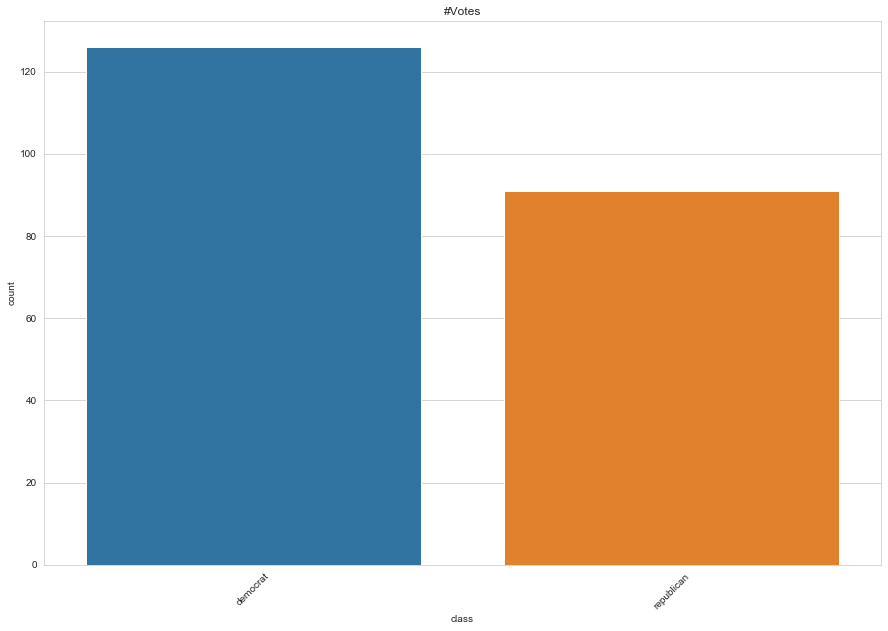

In [83]:
train, train_target, t, t_target = preprocessing(14, False)
rdf = create_rnd_forest(train, train_target, criterion="entropy", n_estimators=200, min_samples_leaf=2, ccp_alpha=0.001, min_samples_split=0.01)
classification = rdf.predict(test)
result = test.copy()
result["class"] = classification
plot_result_classes(result)

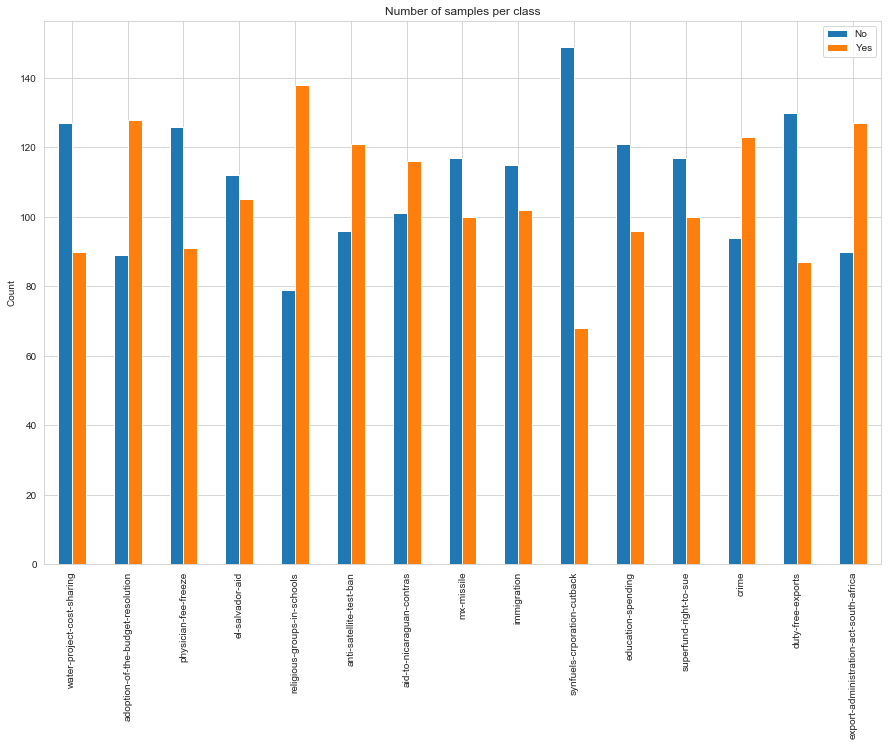

In [84]:
plot_count(test)

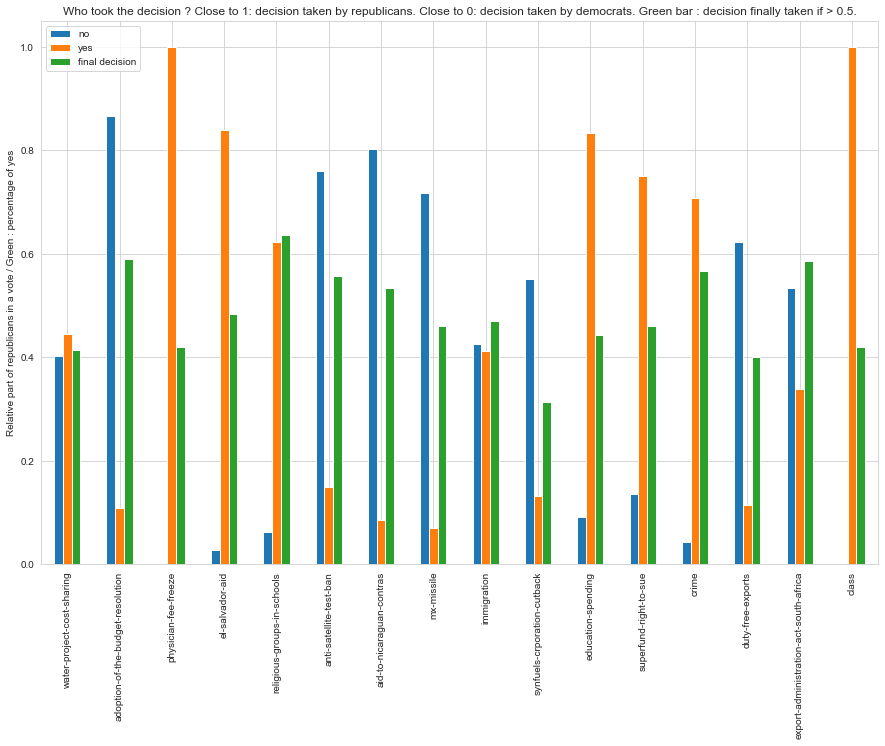

In [85]:
plot_decisions(result, False)

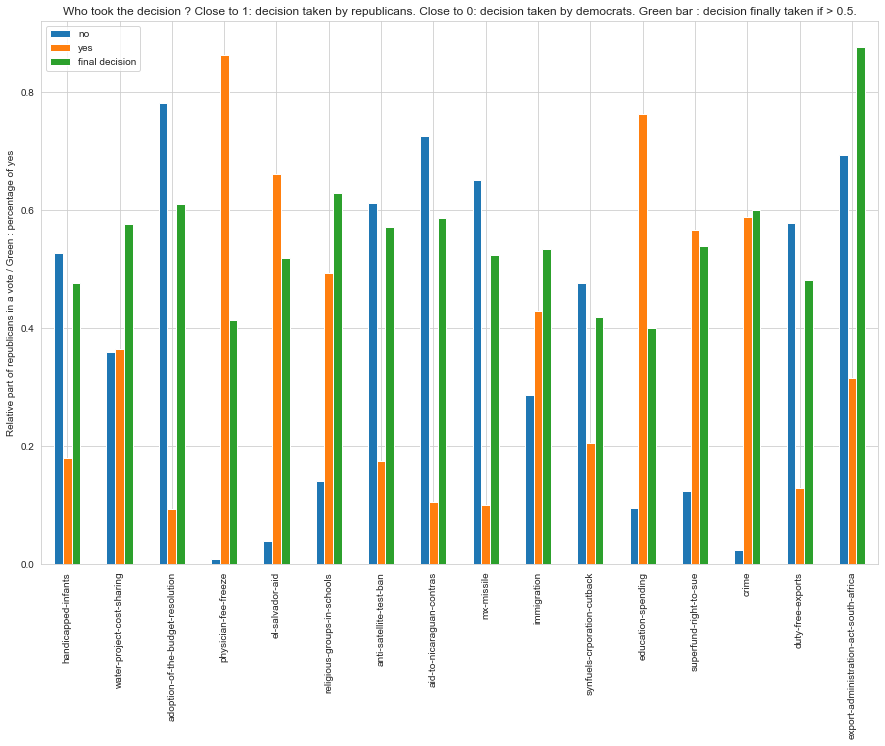

In [86]:
# compare with training
plot_decisions(training_for_plot, False)

What we can say about these two lasts figures is that it seems really accurate, with a very similar repartition of republican voters for every response on each vote between the training dataset and the testset.

# Creation of Kaggle submission

In [87]:
def create_csv(number, predict) :
    res = pd.DataFrame(test_init["ID"], columns = ["ID"])
    final_predict = []
    for binary in predict :
        if binary > 0.5 :
            final_predict.append("republican")
        else :
            final_predict.append("democrat")
    res["class"] = final_predict
    path = "./try" + str(number) + ".csv"
    res.to_csv(path, index=False)

In [88]:
train, train_target, t, t_target = preprocessing(14, False)
rdf = create_rnd_forest(train, train_target, criterion="entropy", n_estimators=200, min_samples_leaf=2, ccp_alpha=0.001, min_samples_split=0.01)
create_csv(1, rdf.predict(test))

train, train_target, t, t_target = preprocessing(16, False)
ppn = create_perceptron(train, train_target, eta0=0.2, max_iter=10, penalty='elasticnet', tol=0.0001)
create_csv(2, rdf.predict(test))